# Tensor Flow with High density, trained with weighted Loss function

In [9]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from graph_nets import utils_np
from trackml.dataset import load_event

from heptrkx.nx_graph.utils_plot import plot_networkx
from heptrkx.nx_graph.utils_data import correct_networkx
from heptrkx.nx_graph.utils_data import merge_truth_info_to_hits
from heptrkx.postprocess.evaluate_tf import create_evaluator
from heptrkx import load_yaml

import os
import glob

In [7]:
config_file = '../configs/train_edge_classifier_kaggle.yaml'
input_ckpt = '/global/project/projectdirs/atlas/xju/heptrkx/models/trackml/nxgraph_big_007/bak'
iteration = 89908

model = create_evaluator(config_file, iteration, input_ckpt)

W1031 16:38:07.633769 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/base.py:177: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W1031 16:38:07.710573 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/base.py:278: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1031 16:38:07.711924 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/base.py:579: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Total Events: 4786 with 16 sections, total 76576 files 
Training data: [0, 3827] events, total 61248 files
Testing data:  [3828, 4786] events, total 15328 files
Training and testing graphs are selected sequantially from their corresponding pools


W1031 16:38:08.459224 46912496622976 deprecation.py:506] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/basic.py:126: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1031 16:38:08.461062 46912496622976 deprecation.py:506] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/basic.py:131: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1031 16:38:09.646521 46912496622976 deprecation_wrapper.py:119] From /global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/postprocess/evaluate_tf.py:5

In [16]:
config = load_yaml(config_file)
file_dir = config['make_graph']['out_graph']
hits_graph_dir = config['data']['input_hitsgraph_dir']
trk_dir = config['track_ml']['dir']

base_dir =  os.path.join(file_dir, "event{:09d}_g{:09d}_INPUT.npz")
true_features = ['pt', 'particle_id', 'nhits']

In [17]:
print(file_dir)

/global/cscratch1/sd/xju/heptrkx/data/nxgraphs_big_000


In [18]:
evtid = 1391
isec = -1
batch_size = 4

In [19]:
file_names = []
if isec < 0:
    section_patten = base_dir.format(evtid, 0).replace('_g{:09}'.format(0), '*')
    n_sections = int(len(glob.glob(section_patten)))
    file_names = [(base_dir.format(evtid, ii), ii) for ii in range(n_sections)]
else:
    file_names = [(base_dir.format(evtid, isec), isec)]

In [20]:
n_batches = len(file_names)//batch_size if len(file_names)%batch_size==0 else len(file_names)//batch_size + 1
split_inputs = np.array_split(file_names, n_batches)

In [26]:
dd = os.path.join(trk_dir, 'event{:09d}')
hits, particles, truth = load_event(dd.format(evtid), parts=['hits', 'particles', 'truth'])
hits = merge_truth_info_to_hits(hits, particles, truth)
true_features = ['pt', 'particle_id', 'nhits']

In [22]:
%%time
all_graphs = []
is_digraph = True
is_bidirection = False
# evaluate each graph
for ibatch in range(n_batches):
    ## pad batch_size
    current_files = list(split_inputs[ibatch])
    if len(current_files) < batch_size:
        last_file = current_files[-1]
        current_files += [last_file] *(batch_size-len(current_files))

#     print(current_files)
    input_graphs = []
    target_graphs = []
    for items in current_files:
        file_name = items[0]
        with np.load(file_name) as f:
            input_graphs.append(dict(f.items()))

        with np.load(file_name.replace("INPUT", "TARGET")) as f:
            target_graphs.append(dict(f.items()))

    graphs = model(utils_np.data_dicts_to_graphs_tuple(input_graphs),
                   utils_np.data_dicts_to_graphs_tuple(target_graphs),
                   use_digraph=is_digraph, bidirection=is_bidirection
                  )
    if len(graphs) != batch_size:
        raise ValueError("graph size not the same as batch-size")

    # decorate the graph with truth info
    for ii in range(batch_size):
        idx = int(current_files[ii][1])
        id_name = os.path.join(hits_graph_dir, "event{:09d}_g{:03d}_ID.npz".format(evtid, idx))
        with np.load(id_name) as f:
            hit_ids = f['ID']

        for node in graphs[ii].nodes():
            hit_id = hit_ids[node]
            graphs[ii].node[node]['hit_id'] = hit_id
            graphs[ii].node[node]['info'] = hits[hits['hit_id'] == hit_id][true_features].values
        
        graphs[ii].graph['info'] = [idx] ## section ID

    all_graphs += graphs

total_graphs 4
total_graphs 4
total_graphs 4
total_graphs 4
CPU times: user 7min 14s, sys: 52.7 s, total: 8min 7s
Wall time: 4min 20s


#### Analyze these graphs. Edge features include 'predict' for predictions and 'solution' for truth

In [23]:
from heptrkx.nx_graph import utils_plot

In [24]:
import sklearn.metrics
fontsize=16
minor_size=14
def plot_metrics2(odd, tdd, odd_th=0.5, tdd_th=0.5, outname='roc_graph_nets.eps'):
    y_pred, y_true = (odd > odd_th), (tdd > tdd_th)
    accuracy  = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall    = sklearn.metrics.recall_score(y_true, y_pred)

    print('Accuracy:            %.4f' % accuracy)
    print('Precision (purity):  %.4f' % precision)
    print('Recall (efficiency): %.4f' % recall)

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, odd)


    fig, ax0 = plt.subplots(figsize=(6, 6), constrained_layout=True)

    # Plot the model outputs
    # binning=dict(bins=50, range=(0,1), histtype='step', log=True)
    binning=dict(bins=50, histtype='step', log=True)
    ax0.hist(odd[y_true==False], lw=2, label='fake', **binning)
    ax0.hist(odd[y_true], lw=2, label='true', **binning)
    ax0.set_xlabel('Model output', fontsize=fontsize)
    ax0.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
    ax0.set_xlim(0, 1)
    ax0.legend(loc=0, fontsize=fontsize)

    plt.savefig(outname)

Accuracy:            0.993562
Precision (purity):  0.957573
Recall (efficiency): 0.959093


/global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/nx_graph/utils_plot.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(outname)
/global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


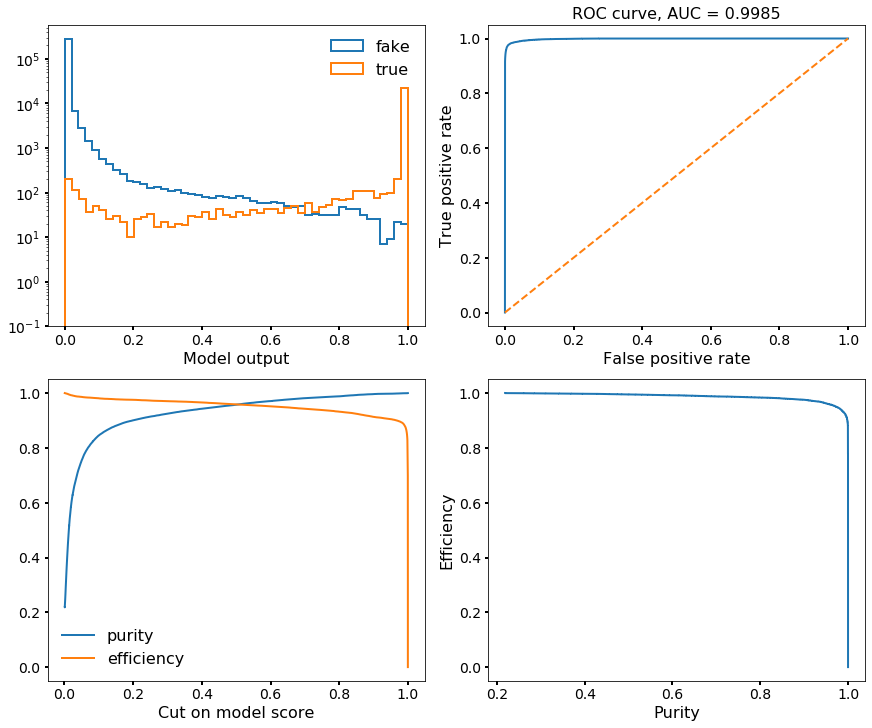

In [25]:
weights = []
truths = []
for G in all_graphs:
    weights += [G.edges[edge]['predict'][0] for edge in G.edges()]
    truths += [G.edges[edge]['solution'][0] for edge in G.edges()]
    
weights = np.array(weights)
truths = np.array(truths)
utils_plot.plot_metrics(weights, truths, odd_th=0.5)
# plot_metrics2(weights, truths, odd_th=0.5)

In [33]:
from heptrkx.postprocess import wrangler, analysis

In [34]:
all_true_tracks = wrangler.get_tracks(G, feature_name='solution')
all_predict_tracks = wrangler.get_tracks(G, feature_name='predict')
true_df = analysis.graphs_to_df(all_true_tracks)
pred_df = analysis.graphs_to_df(all_predict_tracks)
total_particles = np.unique(true_df.merge(truth, on='hit_id', how='left')['particle_id'])
print(len(total_particles))

703


In [35]:
th = 0.

In [36]:
good_pids, bad_pids = analysis.label_particles(pred_df, truth, th, ignore_noise=True)
good_trks = hits[hits['particle_id'].isin(good_pids)]

In [39]:
def print_info(res_pred):
    print(res_pred['n_correct'], res_pred['n_wrong'])

In [40]:
res_pred = analysis.summary_on_prediction(G, good_trks, pred_df)
print("Prediction Info")
print_info(res_pred)
print("True Info")
res_truth = analysis.summary_on_prediction(G, good_trks, true_df)
print_info(res_truth)

Track ML score:  0.5539014905253343
Prediction Info
627 -250
True Info
Track ML score:  0.5814894255504931
642 -265


In [45]:
%%time
eff, purity, true_ones, fake_ones = analysis.trk_eff_purity(all_true_tracks, all_predict_tracks)
print("efficiency:", eff)
print("purity:", purity)

efficiency: 0.8704784130688448
purity: 0.9221260815822002
CPU times: user 3min 52s, sys: 1.65 s, total: 3min 53s
Wall time: 3min 53s
